# Задание 2. User segmentation

Описание:
Для понимания структуры платящих пользователей очень часто используются алгоритмы кластеризации, изначально мы не знаем какие классы удастся выделить и сколько их будет. В общем случае нам интересно выделить пользователей, которые приносят в наш продукт большую часть денег, пользователей которые представляют некий портрет среднего пользователя нашего продукта и пользователей, которые по каким-то причинам не очень охотно платят. 

В качестве “подопытного кролика” предлагается рассмотреть набор данных PaymentsInfoDataset.csv со следующей структурой:

CustomerId - уникальный идентификатор пользователя

Monetary - объем средств, который пользователь принес в продукт за анализируемый период времени

Recency -  время последнего платежа пользователя за анализируемый период времени

Frequency - количество платежей, которое пользователь совершил за анализируемый период времени

factor_* - замаскированные показатели

Есть описательные статистики разных  пользователей. Найдите среди всех пользователей похожие группы, проведите кластерный анализ и подумайте есть ли здесь вообще зависимости или нет? 


Задачи:

1 - Необходимо разработать модель, которая позволит разделить пользователей на классы по их платежному поведению, должна получится ясная картина того, в какой класс попал каждый пользовать и почему, количество классов определяете Вы, руководствуясь аналитикой и здравым смыслом. Возможна ситуация, когда ряд пользователь не попал ни в один из выделенных классов, таких пользователей можно отнести к классу Other, но он не должен быть слишком большим, не забывайте, что цель разработки данной модели -  понять структуру платящих пользователей продукта, а не запутаться еще больше. В качестве основы модели могут использоваться алгоритмы машинного обучения или методы классической аналитики.

2 - показать средние значения факторов в разных кластерах

3 - ответить на вопрос, какие из факторов не несут информации. Ответом на Задание 3 являются названия факторов без какой-либо информации через запятую

4 - в коде напишите, какие кластеры Вы выделили и почему

5 - визуализируйте кластеры

In [35]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd
#from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import random
import statsmodels

Исходная модель

Explained variation per principal component: [9.99573744e-01 4.18501770e-04 2.61992820e-06]


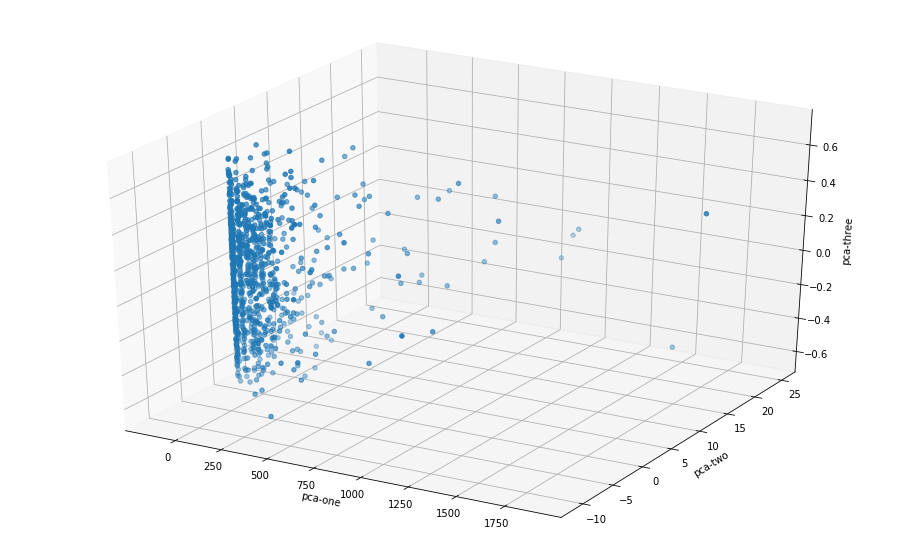

In [25]:
segment_directory = "segmentation.csv"

segment = pd.read_csv(segment_directory, header=0 )

pca = PCA(n_components=3)
pca_result = pca.fit_transform(segment[['Monetary' ,'Frequency'
                                       ,'factor_1' ,'factor_3' , 'factor_4']].values)
segment['pca-one'] = pca_result[:,0]
segment['pca-two'] = pca_result[:,1] 
segment['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

rndperm = list(range(1,1000))

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=segment.loc[rndperm,:]["pca-one"], 
    ys=segment.loc[rndperm,:]["pca-two"], 
    zs=segment.loc[rndperm,:]["pca-three"], 
    
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

# 1. Описательная статистика

In [5]:
segment = pd.read_csv(segment_directory, header=0 )
segment.head()

,CustomerId,Monetary,Recency,Frequency,factor_1,factor_2,factor_3,factor_4
0,8b4f8c66-7589-4734-8ada-2d42f60540ab,100.40,2019-06-04,6,0.35,0.08,0.609740,0.949383
1,2151b2a2-8867-4986-9e00-449c2b4f89e9,170.00,2019-05-25,4,0.66,0.16,0.942272,0.479846
2,3111db79-6721-4ec0-82b1-30b810649c5e,70.75,2019-05-25,6,0.92,0.20,0.323030,0.007076
3,9cb76426-cc5d-4fa3-88bc-b92314b9f4e8,75.00,2019-03-20,10,0.35,0.78,0.876833,0.088974
4,5d86caeb-2d53-44a7-b379-7f15f06ca821,94.51,2019-04-10,5,0.51,0.44,0.912099,0.206194


In [6]:
segment.describe()

,Monetary,Frequency,factor_1,factor_2,factor_3,factor_4
count,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000
mean,129.972264,3.950687,0.500008,0.497864,0.495451,0.498427
std,179.809263,5.189864,0.290144,0.291103,0.289034,0.288478
min,0.000000,1.000000,0.000000,0.000000,0.000037,0.000033
25%,20.910000,1.000000,0.250000,0.240000,0.242545,0.248739
50%,59.275000,2.000000,0.500000,0.500000,0.496410,0.498833
75%,170.000000,5.000000,0.750000,0.750000,0.744476,0.747424
max,3040.000000,111.000000,1.000000,1.000000,0.999996,0.999943


Из описания данных видно,что все факторы изменяются от 0 до 1. Объем платежей варьируется от 0 до 3040, при этом средний объем составляет 130. Также, выжным показателем является количество платежей, которое изменяется от 0 до 111 и в среднем составляет 4 шт.

Оценим объем платежей,на который чаще всего клиенты совершают платежи

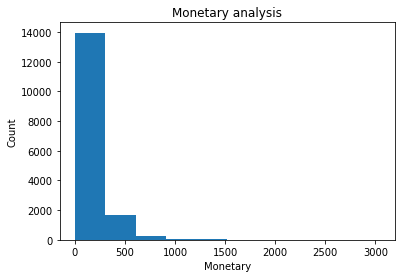

In [22]:
plt.hist(segment['Monetary'] )
plt.xlabel('Monetary')
plt.ylabel('Сount')
plt.title("Monetary analysis")
plt.show()

На графике видно 5 классов по объему.

Оценим степень влияния факторов на объем и количество платежей по матрице корреляции.

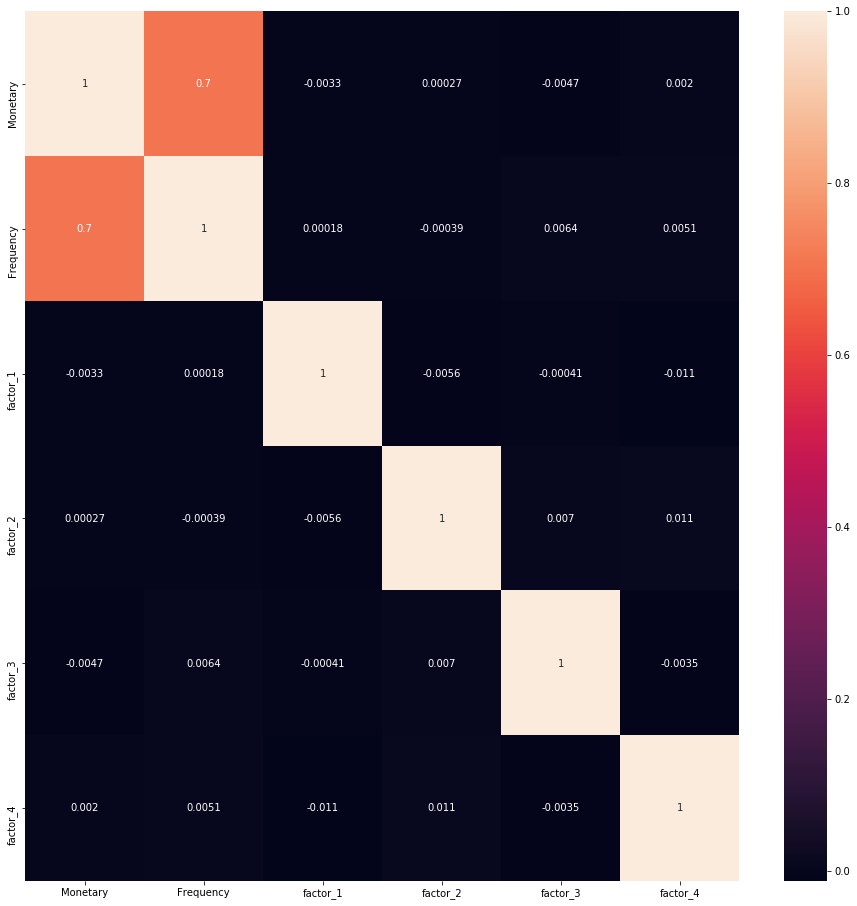

In [7]:
plt.figure(figsize=(16,16))
sns.heatmap(segment.corr(),annot=True)

Из матрицы видно, что на объем платежей больше всего влияет их количество (что очень логично). Самым влиятельным фактором является factor_3. А на количество платежей больше всего влияют факторы factor_3 и factor_4.

Оценим влияние количества платежей на объем средств.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


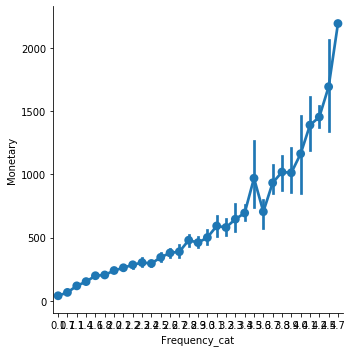

In [12]:
segment['Frequency_cat'] = round(np.log(segment['Frequency']+0.1),1)
sns.factorplot('Frequency_cat','Monetary',data=segment, figsize=(20,30))
plt.show()

По данному графику видно,что количество платежей монотонно увеличивается до объема равному 1000, после чего поступление средст снижается на небольшой промежуток времени. Возможно,стоит выделить таких клиентов в один класс.

Построим диаграммы рассеивания, чтобы оценить влияние факторов на объем средств.

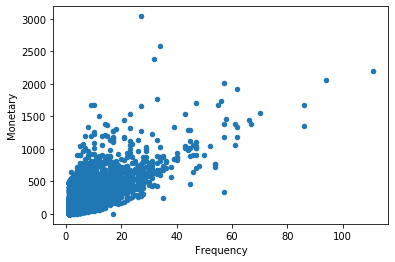

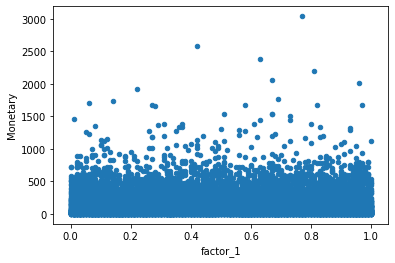

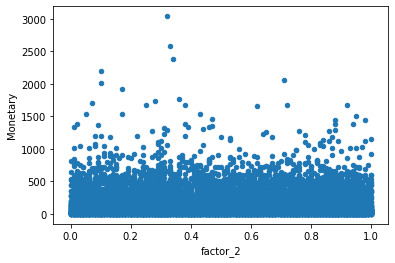

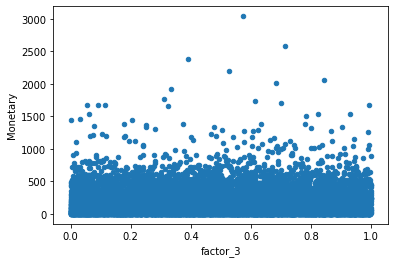

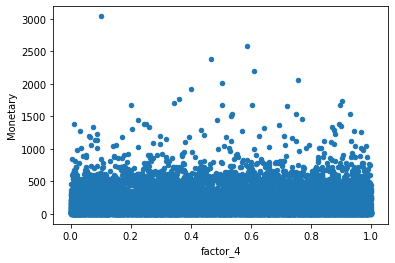

In [15]:
segment.plot.scatter(x='Frequency', y='Monetary')
segment.plot.scatter(x='factor_1', y='Monetary')
segment.plot.scatter(x='factor_2', y='Monetary')
segment.plot.scatter(x='factor_3', y='Monetary')
segment.plot.scatter(x='factor_4', y='Monetary')

По первому графику видно,что наибольшая концентрация платежей наблюдается в объеме до 1000, а количество платежей варьируется от 0 до 40. Также видно, что факторы не сильно влияют на эту целеыую переменную.

Построим диаграммы рассеивания, чтобы оценить влияние факторов на количество платежей.

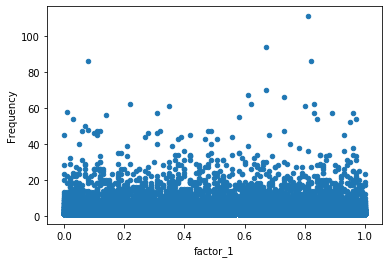

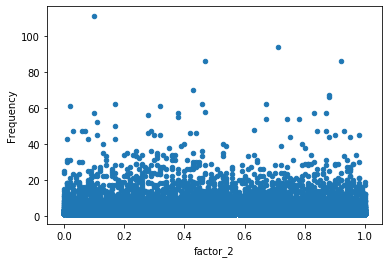

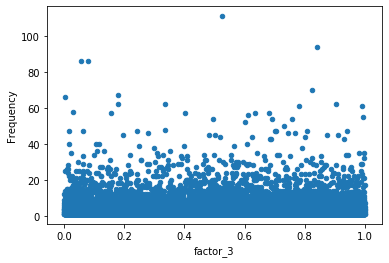

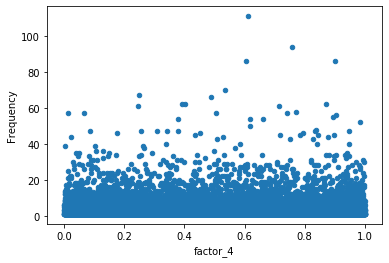

In [16]:
segment.plot.scatter(x='factor_1', y='Frequency')
segment.plot.scatter(x='factor_2', y='Frequency')
segment.plot.scatter(x='factor_3', y='Frequency')
segment.plot.scatter(x='factor_4', y='Frequency')

Подробнее расмотрим зависимость между объемом и количеством платежей.

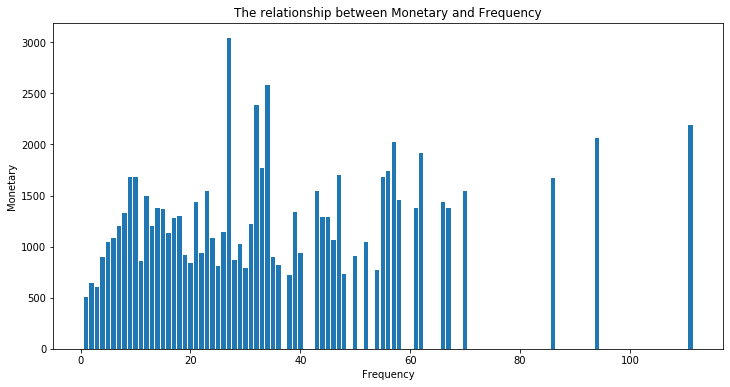

In [19]:
fig, ax = plt.subplots()
ax.bar(segment['Frequency'],segment['Monetary'])
fig.set_figwidth(12)    
fig.set_figheight(6)  
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.title("The relationship between Monetary and Frequency")
plt.show()

По графику видно,что нет четкой зависимости между объемом и количеством платежей.Объем большинства платежей меньше 1000, а после 70 платежей их количество резко снижается.

# Вывод

Исходя из описательной сатистики можно выделить 4 класса пользователей в зависимости от объема платежей:
1. от 0 до 500
2. от 500 до 1000
3. от 1000 до 1500
4. более 1500

Первый класс самый распространенный. Третий клас отражает тех пользователей, которые постепенно перестают вносить средства. Для увеличения прибыльности необходимо завлекать именно таких пользователей.

Из описательной статистики не удалось выделить явные зависимости между объемом и количеством платежей и факторами. Но тем неменее, стоит отметить, что factor_3 больше всего влияет на объем платежей,а factor_3 и factor_4 на количество.

Факторы не несущие информацию: CustomerId,Recency,factor_1,factor_2,,factor_4,factor_5.
